In [ ]:
%%writefile kaggle.json
{"username":"","key":""}

Writing kaggle.json


In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d 'potatohd404/tpdne-60k-128x128'
!mkdir input
!unzip "tpdne-60k-128x128.zip" -d input

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: input/tpdne 60k 128x128/59499.png  
  inflating: input/tpdne 60k 128x128/595.png  
  inflating: input/tpdne 60k 128x128/5950.png  
  inflating: input/tpdne 60k 128x128/59500.png  
  inflating: input/tpdne 60k 128x128/59501.png  
  inflating: input/tpdne 60k 128x128/59502.png  
  inflating: input/tpdne 60k 128x128/59503.png  
  inflating: input/tpdne 60k 128x128/59504.png  
  inflating: input/tpdne 60k 128x128/59505.png  
  inflating: input/tpdne 60k 128x128/59506.png  
  inflating: input/tpdne 60k 128x128/59507.png  
  inflating: input/tpdne 60k 128x128/59508.png  
  inflating: input/tpdne 60k 128x128/59509.png  
  inflating: input/tpdne 60k 128x128/5951.png  
  inflating: input/tpdne 60k 128x128/59510.png  
  inflating: input/tpdne 60k 128x128/59511.png  
  inflating: input/tpdne 60k 128x128/59512.png  
  inflating: input/tpdne 60k 128x128/59513.png  
  inflating: input/tpdne 60k 128x128/59514.png  
  inf

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import random
tf.random.set_seed(69)
random.seed(69)
np.random.seed(69)

## LOADING DATASET

images = []
for i in range(30000):
    dirname = '/content/input/tpdne 60k 128x128/' + str(i+1) + '.png'
    img = cv2.imread(dirname)
    images.append(img)

images = np.array(images)

In [ ]:
images.shape

(30000, 128, 128, 3)

In [ ]:
train, valid, test = images[:20000,:], images[20000:25000,:], images[25000:,:]

In [ ]:
train = train / 255
valid = valid / 255
test = test / 255

In [ ]:
train.shape, test.shape, valid.shape

((20000, 128, 128, 3), (5000, 128, 128, 3), (5000, 128, 128, 3))

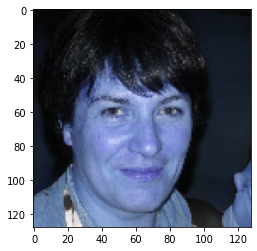

In [ ]:
plt.imshow(train[0])

In [ ]:
train[0]

array([[[0.03529412, 0.03529412, 0.03137255],
        [0.02745098, 0.03137255, 0.03137255],
        [0.01960784, 0.02352941, 0.02352941],
        ...,
        [0.05098039, 0.05882353, 0.0627451 ],
        [0.04313725, 0.05490196, 0.05490196],
        [0.05098039, 0.05882353, 0.05490196]],

       [[0.02745098, 0.02745098, 0.02745098],
        [0.02352941, 0.03137255, 0.03137255],
        [0.02745098, 0.03137255, 0.03137255],
        ...,
        [0.03137255, 0.03921569, 0.03921569],
        [0.03921569, 0.04313725, 0.04705882],
        [0.04313725, 0.04705882, 0.04313725]],

       [[0.02745098, 0.03137255, 0.03137255],
        [0.02745098, 0.03137255, 0.03137255],
        [0.03529412, 0.03921569, 0.04313725],
        ...,
        [0.02745098, 0.03137255, 0.03137255],
        [0.02352941, 0.03137255, 0.03137255],
        [0.02352941, 0.03137255, 0.03137255]],

       ...,

       [[0.45098039, 0.55294118, 0.70588235],
        [0.43137255, 0.54117647, 0.71764706],
        [0.40784314, 0

In [ ]:
del images

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model


from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [ ]:
INPUT_DIM = (128,128,3) # Image dimension
BATCH_SIZE = 128
Z_DIM = 512 # Dimension of the latent vector (z)

In [ ]:
# ENCODER
def build_vae_encoder(input_dim, output_dim, conv_filters, conv_kernel_size,
                  conv_strides, use_batch_norm = False, use_dropout = False):
 
  global K
  K.clear_session()
 
  n_layers = len(conv_filters)
 
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  x = encoder_input
 
  for i in range(n_layers):
      x = Conv2D(filters = conv_filters[i],
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i],
                  padding = 'same',
                  name = 'encoder_conv_' + str(i)
                  )(x)
      if use_batch_norm:
        x = BathcNormalization()(x)
 
      x = LeakyReLU()(x)
 
      if use_dropout:
        x = Dropout(rate=0.25)(x)
 
  shape_before_flattening = K.int_shape(x)[1:] 
 
  x = Flatten()(x)
 
  mean_mu = Dense(output_dim, name = 'mu')(x)
  log_var = Dense(output_dim, name = 'log_var')(x)
 
  def sampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.)
    return mean_mu + K.exp(log_var/2)*epsilon   
 
  encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])
 
  return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, Model(encoder_input, encoder_output)
 
vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder  = build_vae_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM,
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

In [ ]:
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, 
                  conv_strides):

  n_layers = len(conv_filters)

  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)

  for i in range(n_layers):
      x = Conv2DTranspose(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'decoder_conv_' + str(i)
                  )(x)
      
      if i < n_layers - 1:
        x = LeakyReLU()(x)
      else:
        x = Activation('sigmoid')(x)

  decoder_output = x

  return decoder_input, decoder_output, Model(decoder_input, decoder_output)
 
vae_decoder_input, vae_decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = vae_shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2])

In [ ]:
vae_input = vae_encoder_input
vae_output = vae_decoder(vae_encoder_output) 
vae_model = Model(vae_input, vae_output)

vae_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 64, 64, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 32, 32, 64)   18496       leaky_re_lu[0][0]                
____________________________________________________________________________________________

In [ ]:
type(train[0][0][0][0])

numpy.float64

In [ ]:
LEARNING_RATE = 0.0005
N_EPOCHS = 100
LOSS_FACTOR = 10000
 
def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss
 
def total_loss(y_true, y_pred):
    return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])
 
adam_optimizer = Adam(lr = LEARNING_RATE)
 
vae_model.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])
 
# checkpoint_vae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'VAE/weights.h5'), save_weights_only = True, verbose=1)
 
vae_model.fit(train, train,
                epochs=N_EPOCHS,
                batch_size=128,
                shuffle=True,
                validation_data=(valid, valid))

# steps_per_epoch=NUM_IMAGES / BATCH_SIZE,
# callbacks=[checkpoint_vae]

Train on 20000 samples, validate on 5000 samples
Epoch 1/100
20000/20000 [==============================] - ETA: 0s - loss: 414.2168 - r_loss: 0.0390 - kl_loss: 24.1223

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


20000/20000 [==============================] - 18s 903us/sample - loss: 414.2168 - r_loss: 0.0390 - kl_loss: 24.1223 - val_loss: 278.0038 - val_r_loss: 0.0240 - val_kl_loss: 37.9134
Epoch 2/100
20000/20000 [==============================] - 15s 736us/sample - loss: 261.4147 - r_loss: 0.0219 - kl_loss: 42.4081 - val_loss: 251.5092 - val_r_loss: 0.0208 - val_kl_loss: 43.8256
Epoch 3/100
20000/20000 [==============================] - 15s 735us/sample - loss: 245.4584 - r_loss: 0.0198 - kl_loss: 47.2670 - val_loss: 239.9880 - val_r_loss: 0.0191 - val_kl_loss: 48.8385
Epoch 4/100
20000/20000 [==============================] - 15s 735us/sample - loss: 235.3165 - r_loss: 0.0186 - kl_loss: 49.5488 - val_loss: 229.7429 - val_r_loss: 0.0181 - val_kl_loss: 49.1871
Epoch 5/100
20000/20000 [==============================] - 15s 734us/sample - loss: 222.5648 - r_loss: 0.0173 - kl_loss: 49.3731 - val_loss: 215.8597 - val_r_loss: 0.0168 - val_kl_loss: 47.5078
Epoch 6/100
20000/20000 [=================

In [ ]:
decoded_imgs = vae_model.predict(test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


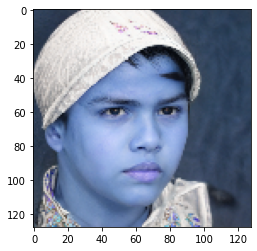

In [ ]:
plt.imshow(test[17])

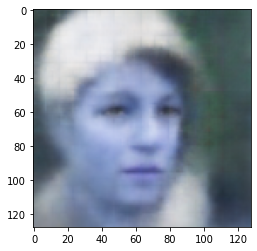

In [ ]:
plt.imshow(decoded_imgs[17])

In [ ]:
predict_vects = vae_encoder.predict(test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
predict_vects.shape

(5000, 512)

In [ ]:
with open('stylegan_latent_vectors.npy', 'wb') as f:
    np.save(f, predict_vects)

In [ ]:
vae_encoder.save('stylegan_encoder.h5')
vae_decoder.save('stylegan_decoder.h5')
vae_model.save('stylegan_model.h5')